In [1]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import warnings
warnings.filterwarnings('ignore')

from folium import plugins
import json
import requests
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

import seaborn as sns
import matplotlib.pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html

from jupyter_plotly_dash import JupyterDash

import time

import plotly.graph_objects as go
import numpy as np

In [2]:
# load data
data=pd.read_excel('I:/Brandschadenstatistik_Recycling.xlsx')
data=data.drop(index=[0,1])
data=data.reset_index(drop=True)
data.isna().sum()

Nr.                                       0
Tag                                       2
Datum                                     0
Uhrzeit                                  39
Firma                                    47
Land                                      0
Ort                                       1
Brandentstehungsort                      18
Brandursache                             10
Brandherd                                16
Art des in Brand geratenen Materials     56
Branderkennung durch                    191
Unnamed: 12                             272
Unnamed: 13                             208
Unnamed: 14                             242
Brandbekämpfung                         254
Unnamed: 16                             268
Unnamed: 17                              20
Folgeschaden                            268
Brand-\nvorschäden                      226
Schadenhöhe                             213
Link                                      5
Unnamed: 22                     

In [3]:
# pickup the useful information 
df=data[['Datum','Uhrzeit','Firma','Ort','Brandentstehungsort','Brandherd','Art des in Brand geratenen Materials']]
df.head()

,Datum,Uhrzeit,Firma,Ort,Brandentstehungsort,Brandherd,Art des in Brand geratenen Materials
0,2019-06-16,22:00:00,Berliner Stadtreinigung,Berlin Neukölln,Lagerhalle,Lagergut,"6000 Tonnen Haus- und Sperrmüll, Müllbunker"
1,2020-02-15,09:00:00,Alfred Hösli AG,Weesen,Halle,Arbeitsmaschinen,Abbruchfahrzeuge
2,2018-08-18,NaN,CRH Recycling,Crailsheim,Fahrzeug,Müllpresswagen,"Abfall aus Müllwagen, Schaden am Asphalt"
3,2019-09-04,NaN,Mittelstädt,Uslar,Freilager,Lagergut,Altholz
4,2019-05-13,12:50:00,Heidemann Recycling GmbH,Düdenbüttel,Freilager,Lagergut,Altholz und Bauschutt


In [4]:
df_geo=df.copy()

# get longtitude and latitude
locator=Nominatim()
geocode=RateLimiter(locator.geocode)
df_geo['location']=df_geo['Ort'].apply(geocode)
df_geo['point']=df_geo['location'].apply(lambda loc:tuple(loc.point) if loc else None)
df_geo[['latitude','logitude','altitude']]=pd.DataFrame(df_geo['point'].tolist(),index=df.index)
df_geo=df_geo.drop(['location','point'],axis=1)
df_geo=df_geo.dropna(subset=['latitude','logitude'])                                

In [106]:
# overveiw of location
def my_map_overview(df_geo):
    my_map=folium.Map(
    location=[48,14],
    tiles='cartodbpositron',
    zoom_start=4,
    width=1400,
    height=1000
    )
    
    latitudes=list(df_geo.latitude)
    longitudes=list(df_geo.logitude)
    labels=list(df_geo.Firma)
    
    # instantiate a mark cluster object for the incidents in the dataframe
    incidents = folium.map.FeatureGroup()
    
    for lat,lng,label in zip(latitudes,longitudes,labels):
        folium.CircleMarker([lat,lng],popup=label,radius=2,color='red',fill_color='yellow').add_to(my_map)
    
    my_map.add_child(incidents)
    
    # add EU border

    EU_geo = 'I:/EU.geo.json'
    folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'blue',
        'weight': 1,
        'dashArray': '1, 1'}).add_to(my_map)
    
    return my_map

my_map_overview=my_map_overview(df_geo)
my_map_overview.save('my_map_overview.html')
my_map_overview

In [72]:
# details about the location 

def my_map_details(df_geo):
    my_map=folium.Map(
    location=[48,14],
    tiles='cartodbpositron',
    zoom_start=4,
    width=1800,
    height=1000
    )
    
    # instantiate a mark cluster object for the incidents in the dataframe
    incidents = plugins.MarkerCluster().add_to(my_map)
    
    # loop through the dataframe and add each data point to the mark cluster
    for lat, lng, label, in zip(df_geo.latitude, df_geo.logitude, df_geo.Firma):
        folium.CircleMarker(
        location=[lat, lng],
        icon=None,
        popup=label,
        radius=2,color='blue',fill_color='yellow').add_to(incidents)
        
    # add incidents to map
    my_map.add_child(incidents)
    
    # add EU border
    EU_geo = 'I:/EU.geo.json'
    folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'blue',
        'weight': 2,
        'dashArray': '2, 1'}).add_to(my_map)
    
    # Convert data format
    heatdata = df_geo[['latitude','logitude']].values.tolist()
    
    # add incidents to map
    HeatMap(heatdata).add_to(my_map)
    
    return my_map

my_map_details=my_map_details(df_geo)
my_map_details.save('my_map_details.html')

In [5]:
# get month, dayofweek information 
df_date_geo=df_geo.copy()
df_date_geo['date']= pd.to_datetime(df_date_geo['Datum'], format='%Y-%m-%d')
df_date_geo['month']=df_date_geo['date'].dt.month
df_date_geo['dayofweek']=df_date_geo['date'].dt.dayofweek

df_dayofweek_list = []
for dayofweek in df_date_geo.dayofweek.sort_values().unique():
    df_dayofweek_list.append(df_date_geo.loc[df_date_geo.dayofweek == dayofweek, ['latitude', 'logitude']].values.tolist())

df_month_list = []
for month in df_date_geo.month.sort_values().unique():
    df_month_list.append(df_date_geo.loc[df_date_geo.month == month, ['latitude', 'logitude']].values.tolist())

In [8]:
def my_map_geo_month(df_date_geo):
    my_map=folium.Map(
        location=[48,14],
        tiles='cartodbpositron',   
        zoom_start=5)
    
    latitudes=list(df_date_geo.latitude)
    longitudes=list(df_date_geo.logitude)
    labels=list(df_date_geo.Firma)


    for lat,lng,label in zip(latitudes,longitudes,labels):
        folium.CircleMarker([lat,lng],popup=label,radius=0.5,color='black',fill_color='black').add_to(my_map)
    
    incidents=folium.map.FeatureGroup()
    my_map.add_child(incidents)

    # add EU border


    EU_geo = 'I:/EU.geo.json'
    folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'gray',
        'weight': 1,
        'dashArray': '1, 3'}).add_to(my_map)

    HeatMapWithTime(df_month_list, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(my_map)
    
    return my_map


In [9]:
def my_map_geo_dayofweek(df_date_geo):
    my_map=folium.Map(
    location=[48,14],
    tiles='cartodbpositron',
    zoom_start=4)

    latitudes=list(df_date_geo.latitude)
    longitudes=list(df_date_geo.logitude)
    labels=list(df_date_geo.Firma)
    
    for lat,lng,label in zip(latitudes,longitudes,labels):
        folium.CircleMarker([lat,lng],popup=label,radius=1,color='black',fill_color='gray').add_to(my_map)

    incidents=folium.map.FeatureGroup()
    my_map.add_child(incidents)

    # add EU border
    EU_geo = 'I:/EU.geo.json'
    folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'gray',
        'weight': 1,
        'dashArray': '1, 3'}).add_to(my_map)    

    HeatMapWithTime(df_dayofweek_list, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(my_map)
    
    return my_map


In [6]:
df_date=df_date_geo.copy()
df_date['dayofweek']=df_date_geo['dayofweek']+1

#dayofweek_counts.plot(figsize=(12,4))
#month_counts.plot(figsize=(12,4))

In [7]:
# 四个时间段？
def Transfer_timeofday1(timeofday):
    h_timeofday=int(timeofday.hour)
    if (h_timeofday<6) and (h_timeofday>=0):
        timeofday_part='EMorning'
    elif (h_timeofday<12) and (h_timeofday>=6):
        timeofday_part='Morning'
    elif (h_timeofday<18) and (h_timeofday>=12):
        timeofday_part='Afternoon'
    else:
        timeofday_part='Evening'
        
    return timeofday_part


def Time_matters(df_date):
    
    dayofweek_counts=df_date['dayofweek'].value_counts()
    dayofweek_counts=dayofweek_counts.to_frame().sort_index()
    dayofweek_counts['day_index']=['Mo','Tu','We','Th','Fr','Sa','Su']

    month_counts=df_date['month'].value_counts()
    month_counts=month_counts.to_frame().sort_index()
    month_counts['mon_index']=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    #sns.pointplot(dayofweek_counts.day_index,dayofweek_counts.dayofweek)
    # sns.pointplot(month_counts.mon_index,month_counts.month)

   
    #-------------
    
    Hour_counts=df_date['Uhrzeit'].value_counts()
    Hour_counts=Hour_counts.to_frame().sort_index()
    mean_fire=Hour_counts.Uhrzeit.mean()
    Hour_counts['MeanFire']=mean_fire    
    Hour_counts['TwoTimesMeanFire']=mean_fire*2
 
    #-------------------------------------------------------------------------

    Hour_counts['Uhrzeit_Uhr']=Hour_counts.index
    Hour_counts['TimeofDay']=Hour_counts['Uhrzeit_Uhr'].apply(lambda x: Transfer_timeofday1(x))
    TimeofDay_part=Hour_counts['TimeofDay'].value_counts()
    TimeofDay_part=TimeofDay_part.to_frame().sort_index()

     #--------------------------------------------------------------------
    Hour_counts['Uhr']=Hour_counts['Uhrzeit_Uhr'].apply(lambda x: int(x.hour))
    perHour_counts=Hour_counts['Uhr'].value_counts()
    perHour_counts=perHour_counts.to_frame().sort_index()
    mean_fire=perHour_counts.Uhr.mean()
    perHour_counts['MeanFire']=mean_fire    
    perHour_counts['TwoTimesMeanFire']=mean_fire*2
    perHour_counts['Uhr_index']=perHour_counts.index
    
    
    return month_counts,dayofweek_counts,Hour_counts,TimeofDay_part,perHour_counts

month_counts,dayofweek_counts,Hour_counts,TimeofDay_part,perHour_counts=Time_matters(df_date)

In [12]:
perHour_counts

,Uhr,MeanFire,TwoTimesMeanFire,Uhr_index
0,3,5.416667,10.833333,0
1,5,5.416667,10.833333,1
2,5,5.416667,10.833333,2
3,4,5.416667,10.833333,3
4,4,5.416667,10.833333,4
5,4,5.416667,10.833333,5
6,8,5.416667,10.833333,6
7,5,5.416667,10.833333,7
8,6,5.416667,10.833333,8
9,4,5.416667,10.833333,9


In [8]:
df_HallMater=data[['Brandentstehungsort','Brandherd','Art des in Brand geratenen Materials','Schadenhöhe']]
df_HallMater.columns=['FireHall','FireSource','FireMaterial','Cost']
df_HallMater.isna().sum()


FireHall         18
FireSource       16
FireMaterial     56
Cost            213
dtype: int64

In [14]:
df_HallMater['FireHall'].value_counts()

Lagerhalle                89
Freilager                 73
Produktion                49
Container                  5
unbekannt                  3
Schuppen                   3
Mehrzweckgebäude           3
Lagerghalle                2
Lagergut                   2
Sortierhalle               2
Fahrzeug                   2
Lastwagen                  2
Schredder                  2
Betriebshalle              2
Bunker                     2
Lagerhallen (4)            1
Materialbunker             1
Lagerhalle (Container)     1
Restmüllcontainer          1
Lüftungssystem             1
Lagerhalle                 1
Lahgerhalle                1
Halle                      1
-                          1
Schredder-Halle            1
Verladung                  1
Sperrgutbunker             1
Schreddermobil             1
Überdachter Lagerplatz     1
Name: FireHall, dtype: int64

In [9]:
# storage matters?
list_rename=['Lagerghalle','Lahgerhalle','Lagerhalle (Container)','Lagerhalle','Lagerhallen (4)']
df_HallMater['FireHall']=df_HallMater['FireHall'].map(lambda x: 'Lagerhalle' if (x in list_rename) else x)

list_rename=['Lagerhalle','Freilager','Produktion']
df_HallMater['FireHall']=df_HallMater['FireHall'].map(lambda x: 'Others' if (x not in list_rename) else x)

In [16]:
df_HallMater['FireSource'].value_counts()
# no information in the 'Brandherd'

Lagergut                           192
Schredder                            9
Förderanlage                         6
Sortieranlage                        6
Presse                               5
Maschine                             3
unbekannt                            3
Zerkleinerer                         2
-                                    2
Kanalballenpresse                    2
Förderband                           2
Arbeitsmaschinen                     1
Radlader/ bagger                     1
Luftfilter                           1
Papierpresse                         1
mobiler Schredder                    1
Lagergut, Förderanlage               1
Metallgestelle                       1
Flurförderfahrzeug                   1
Brenn- und Schmierstoffe             1
Absaugung                            1
Müllsortieranlage                    1
Betriebsstoffe                       1
Schredder, Lagergut, Förderband      1
Aufbereitungsanlage                  1
Lagergut/Hecksler        

In [17]:
df_HallMater['FireMaterial'].value_counts()

Papier                                                 8
Kunststoff                                             6
Restmüll                                               5
Papierballen                                           5
Altpapier                                              5
Kunststoffe                                            5
Elektroschrott                                         5
Metallspäne                                            4
Schrott                                                4
Hausmüll                                               4
Sperrmüll                                              4
Metallschrott                                          2
Lithium-Ionen Batterien                                2
Sperrmüll, Laub + Gartenabfall                         2
unbekannt                                              2
Kompost                                                2
Gewerbeabfall                                          2
Styroporpaletten               

In [10]:
# map into  clusters
Material_clusters   =   ['Hausmull','Electronics','Papers',
                         'Plastic','Mineral','Wood',
                         'Sperrmull',
                         'Textilien','Metal',
                         'Others']

Material_clusters_match=['estmüll|ausmüll|ompost|Grünschnitt|Restabfall|Biomasse','Elektroschrott','apier',
                         'unststoff|lasti','traßenkehricht|auschutt|Filterstaub','olz',
                         'Dachplatten|Matratzen|perr|möbel|Filzmatten',
                         'extil','chrott|etal',
                         'Industrieabfall|Übergriff auf Müllsäcke|Gewerbeabfall|Leichtverpackungen|Ausgelöst|Staub']


In [11]:
Material_cluster_number=[]

for i in list(range(len(Material_clusters))):
    X=np.where(df_HallMater['FireMaterial'].str.contains(Material_clusters_match[i]))
    Material_cluster_number.append(len(X[0]))

Material_cluster=pd.DataFrame(Material_cluster_number,index=Material_clusters,columns =['NumberOfCluster']).sort_values('NumberOfCluster')

Text(0.5, 1.0, 'Material des Feuers')

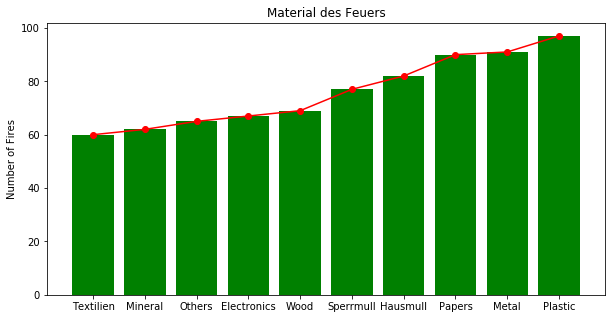

In [12]:
fig=plt.figure(figsize=[10,5])
plt.bar(Material_cluster.index, Material_cluster.NumberOfCluster,color='green')
plt.plot(Material_cluster.index, Material_cluster.NumberOfCluster,color='red',marker='o')
plt.ylabel('Number of Fires')
plt.title('Material des Feuers')

Text(0, 0.5, 'Number of Fires')

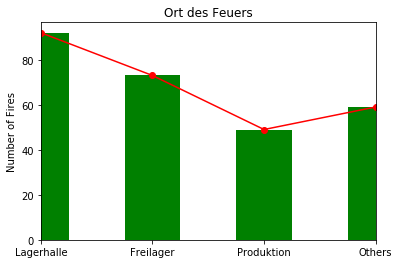

In [13]:

order=['Lagerhalle','Freilager','Produktion','Others']
df_HallMater['FireHall'].value_counts()[order].plot(kind='bar',title='Ort des Feuers',color='g')
df_HallMater['FireHall'].value_counts()[order].plot(kind='line',title='Ort des Feuers',secondary_y=False,color='r',marker='o')
plt.ylabel('Number of Fires')


In [14]:
df_HallMater_counts=df_HallMater['FireHall'].value_counts()[order].to_frame()
df_HallMater_counts['ort_index']=order



In [15]:
# 
df_date_material=data[['Datum','Art des in Brand geratenen Materials']].copy()

df_date_material=df_date_material.dropna(axis=0)
df_April_material=df_date_material[df_date_material['Datum'].dt.month==4]
df_April_material.columns=['Datum','Material']

df_August_material=df_date_material[df_date_material['Datum'].dt.month==8]
df_August_material.columns=['Datum','Material']


In [16]:
Material_cluster_number=[]

for i in list(range(len(Material_clusters))):
    X=np.where(df_April_material['Material'].str.contains(Material_clusters_match[i]))
    Material_cluster_number.append(len(X[0]))

Material_cluster_April=pd.DataFrame(Material_cluster_number,index=Material_clusters,columns =['NumberOfCluster']).sort_values('NumberOfCluster')

In [17]:
Material_cluster_number=[]

for i in list(range(len(Material_clusters))):
    X=np.where(df_August_material['Material'].str.contains(Material_clusters_match[i]))
    Material_cluster_number.append(len(X[0]))

Material_cluster_August=pd.DataFrame(Material_cluster_number,index=Material_clusters,columns =['NumberOfCluster']).sort_values('NumberOfCluster')

Text(0.5, 1.0, 'Material_cluster_August')

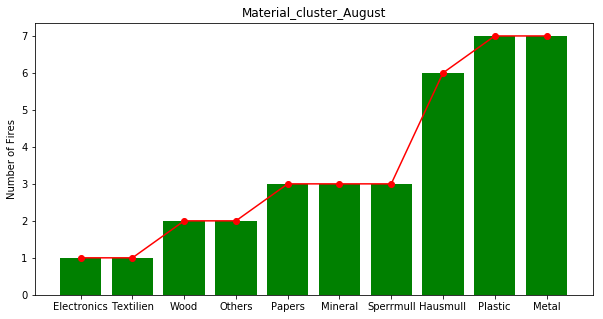

In [18]:
fig=plt.figure(figsize=[10,5])
plt.bar(Material_cluster_August.index, Material_cluster_August.NumberOfCluster,color='green')
plt.plot(Material_cluster_August.index, Material_cluster_August.NumberOfCluster,color='red',marker='o')
plt.ylabel('Number of Fires')
plt.title('Material_cluster_August')

Text(0.5, 1.0, 'Material_cluster_April')

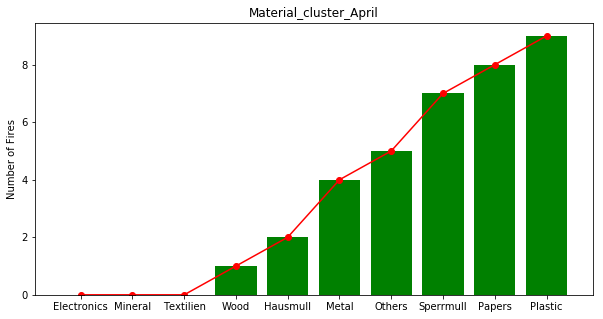

In [19]:
fig=plt.figure(figsize=[10,5])
plt.bar(Material_cluster_April.index, Material_cluster_April.NumberOfCluster,color='green')
plt.plot(Material_cluster_April.index, Material_cluster_April.NumberOfCluster,color='red',marker='o')
plt.ylabel('Number of Fires')
plt.title('Material_cluster_April')

In [79]:
#dash
text_note='''
# Legend

### This is the analysis for the fire accidents happend to the recycling companies in year 2018-2020.
Give the limits of the database, only the times of the fire accidents are being analyzed. 

## The analysis contains:
#### 1. the locations of the recycling companies
#### 2. the numbers of the accidents in each month/ day of the week / time of the day 
#### 3. the fire ort within the company, the materials that caused the fire



'''


app=JupyterDash('Results Display',serve_locally=True)
#app=dash.Dash(__name__)
app.layout=html.Div([
    #html.H2('Fire accidents of recycling companies',style=dict(backgroundColor='yellow')),
    
    html.Div([
         #html.H2('Fire accidents of recycling companies',style=dict(backgroundColor='yellow')),
        
        html.Div([
            
            dcc.Markdown(children=text_note, style={'marginLeft':10},),
        ],
            style=dict(backgroundColor='gray',height='33%',float='left',width='45%')
        ),
        
        
        html.Div([
            
            html.Iframe(srcDoc=open('my_map_overview.html','r').read(),height='100%',width='100%'),
        ],
            style=dict(height='33%',float='right',width='55%',display='inline-block',overflow='hidden')
        ),
        
        
        html.Iframe(srcDoc=open('my_map_details.html','r').read(),height='67%',width='100%'),
        
    ],
          
        style=dict(height='100%',width='49%',display='inline-block')
    ),
        
    
    # right part--------------------------------------------------
    html.Div([
        
        #html.H3('TimeMatters',style=dict(textAlign='left')),
        
        # right line1--------------------------------------------------
        html.Div([
            
            html.Div([
                dcc.Graph(id='First_left',
                          style={
                              'height':'90%',
                              'width':'90%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':0,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':month_counts.mon_index,'y':month_counts.month,'type':'bar','hoverinfo':'none'},
                                   {'x':month_counts.mon_index,'y':month_counts.month,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Month of the Year',
                                         showlegend=False,
                                         margin=dict(l=20,r=0,t=30,b=13),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='60%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='First_right',
                          style={
                              'height':'90%',
                              'width':'90%',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':0,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':dayofweek_counts.day_index,'y':dayofweek_counts.dayofweek,'type':'bar','hoverinfo':'none'},
                                   {'x':dayofweek_counts.day_index,'y':dayofweek_counts.dayofweek,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Day of the Week',
                                         showlegend=False,
                                         
                                         margin=dict(l=20,r=0,t=30,b=13),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='40%',display='inline-block')
        ),
            
        
        
        
        ],
        style=dict(height='33%',width='100%',display='inline-block')
        ),
        
        #-----middle line----------------------------------------------------------------------------------
        html.Div([
            
            html.Div([
                dcc.Graph(id='middle_left',
                          style={
                              'height':'100%',
                              'width':'100%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':0,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
    
                        
                         figure=dict(
                             data=[{'x':perHour_counts.Uhr_index,'y':perHour_counts.MeanFire,'type':'line','mode':'lines','hoverinfo':'no'},
                                   {'x':perHour_counts.Uhr_index,'y':perHour_counts.Uhr,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Uhr of the day',
                                         showlegend=False,
                                         margin=dict(l=20,r=0,t=30,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='65%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='middle_right',
                          style={
                              'height':'100%',
                              'width':'100%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':10,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[#{'x':TimeofDay_part.index,'y':TimeofDay_part.TimeofDay,'type':'bar','hoverinfo':'none'},
                                   {'labels':TimeofDay_part.index,'values':TimeofDay_part.TimeofDay,'type':'pie','hoverinfo':'label+value'},
                                  ],
                             layout=dict(
                                         
                                         title='Quarter of the Day',
                                         showlegend=False,
                                         
                                         margin=dict(l=20,r=0,t=30,b=0),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='35%',display='inline-block')
        ),
            
        
        
        
        ],
        style=dict(height='33%',width='100%',display='inline-block')
        ),
        
        
        
        #---------------------------------------------------------------------------------------------------
        
       #html.H3('MaterialMatters',style=dict(textAlign='center')),
        
        
 html.Div([
            
            html.Div([
                dcc.Graph(id='Bottom_left',
                          style={
                              'height':'90%',
                              'width':'90%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':20,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':df_HallMater_counts.ort_index,'y':df_HallMater_counts.FireHall,'type':'bar','hoverinfo':'none'},
                                   {'x':df_HallMater_counts.ort_index,'y':df_HallMater_counts.FireHall,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Ort within the company',
                                         showlegend=False,
                                         margin=dict(l=30,r=0,t=40,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='40%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='Bottom_right',
                          style={
                              'height':'90%',
                              'width':'90%',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':20,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':Material_cluster.index,'y':Material_cluster.NumberOfCluster,'type':'bar','hoverinfo':'none'},
                                   {'x':Material_cluster.index,'y':Material_cluster.NumberOfCluster,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Matterials',
                                         showlegend=False,
                                         
                                         margin=dict(l=30,r=0,t=40,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='60%',display='inline-block',float='right')
        ),
            
        
        
        
        ],
        style=dict(height='33%',width='100%',display='inline-block',float='right')
        ),
        
        
        
        ],
        
        style=dict(float='right',height='100%',width='49%',display='inline-block')
    )
    
],
    
    style=dict(height='1400px',width='1900px',display='inline-block')
)

app

In [107]:
#dash
text_note='''
# Legend

### This is the analysis for the fire accidents happend to the recycling companies in year 2018-2020.
Give the limits of the database, only the times of the fire accidents are being analyzed. 

## The analysis contains:
#### 1. the locations of the recycling companies
#### 2. the numbers of the accidents in each month/ day of the week / time of the day 
#### 3. the fire ort within the company, the materials that caused the fire



'''


app=JupyterDash('Results Display',serve_locally=True)
#app=dash.Dash(__name__)
app.layout=html.Div([
    #html.H2('Fire accidents of recycling companies',style=dict(backgroundColor='yellow')),
    
    html.Div([
         #html.H2('Fire accidents of recycling companies',style=dict(backgroundColor='yellow')),
        
        html.Div([
            
            dcc.Markdown(children=text_note, style={'marginLeft':20},),
        ],
            style=dict(backgroundColor='gray',height='45%',float='left',width='40%')
        ),
        
        
        html.Div([
            
            html.Iframe(srcDoc=open('my_map_overview.html','r').read(),height='100%',width='100%'),
        ],
            style=dict(height='45%',float='right',width='60%',display='inline-block',overflow='hidden')
        ),
        
        
        html.Iframe(srcDoc=open('my_map_details.html','r').read(),height='55%',width='100%'),
        
    ],
          
        style=dict(height='100%',width='100%',display='inline-block')
    )
],
    
    
style=dict(height='1500px',width='1500px',display='inline-block')


)
        
    

app

In [104]:
dict_of_fig = dict({
    "data": [{"mode": "lines",
              "x": Material_cluster.index,
              "y": Material_cluster.NumberOfCluster}, 
             
             {"type": "bar",
              "x": Material_cluster.index,
              "y": Material_cluster.NumberOfCluster},
             
             
            ],
    
    "layout": {"title": {"text": "Material"},
               'showlegend':False,
               'margin':dict(l=30,r=0,t=40,b=45),
              
              
              }
    
})

fig_Material= go.Figure(dict_of_fig)
#fig_Material.show()

In [27]:
#dash

app=JupyterDash('Results Display',serve_locally=True)
#app=dash.Dash(__name__)
app.layout=html.Div([
    #html.H2('Fire accidents of recycling companies',style=dict(backgroundColor='yellow')),
    
    html.Div([
        
        #html.H3('TimeMatters',style=dict(textAlign='left')),
        
        # line1--------------------------------------------------
        html.Div([
            
            html.Div([
                dcc.Graph(id='First_left',
                          style={
                              'height':'90%',
                              'width':'90%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':0,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':month_counts.mon_index,'y':month_counts.month,'type':'bar','hoverinfo':'none'},
                                   {'x':month_counts.mon_index,'y':month_counts.month,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Month',
                                         showlegend=False,
                                         margin=dict(l=20,r=0,t=30,b=13),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='60%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='First_right',
                          style={
                              'height':'90%',
                              'width':'90%',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':0,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':dayofweek_counts.day_index,'y':dayofweek_counts.dayofweek,'type':'bar','hoverinfo':'none'},
                                   {'x':dayofweek_counts.day_index,'y':dayofweek_counts.dayofweek,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Day',
                                         showlegend=False,
                                         
                                         margin=dict(l=20,r=0,t=30,b=13),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='40%',display='inline-block')
        ),
            
        
        
        
        ],
        style=dict(height='25%',width='100%',display='inline-block')
        ),
        
        #-----middle line----------------------------------------------------------------------------------
        html.Div([
            
            html.Div([
                dcc.Graph(id='middle_left',
                          style={
                              'height':'100%',
                              'width':'100%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':0,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
    
                        
                         figure=dict(
                             data=[{'x':perHour_counts.Uhr_index,'y':perHour_counts.Uhr,'type':'bar','hoverinfo':'no'},
                                   {'x':perHour_counts.Uhr_index,'y':perHour_counts.Uhr,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                   #{'x':perHour_counts.Uhr_index,'y':perHour_counts.MeanFire,'type':'line','mode':'lines','hoverinfo':'no'},
                                   
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Time',
                                         showlegend=False,
                                         margin=dict(l=20,r=0,t=30,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='65%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='middle_right',
                          style={
                              'height':'80%',
                              'width':'80%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':10,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[#{'x':TimeofDay_part.index,'y':TimeofDay_part.TimeofDay,'type':'bar','hoverinfo':'none'},
                                   {'labels':TimeofDay_part.index,'values':TimeofDay_part.TimeofDay,'type':'pie','hoverinfo':'label+value'},
                                  ],
                             layout=dict(
                                         
                                         #title='Quarter of the Day',
                                         showlegend=True,
                                         
                                         margin=dict(l=20,r=0,t=30,b=0),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='35%',display='inline-block')
        ),
            
        
        
        
        ],
        style=dict(height='25%',width='100%',display='inline-block')
        ),
        
        
        
        #---------------------------------------------------------------------------------------------------
        
       #html.H3('MaterialMatters',style=dict(textAlign='center')),
        
        
 html.Div([
            
            html.Div([
                dcc.Graph(id='Bottom_left',
                          style={
                              'height':'90%',
                              'width':'90%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':20,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':df_HallMater_counts.ort_index,'y':df_HallMater_counts.FireHall,'type':'bar','hoverinfo':'none'},
                                   {'x':df_HallMater_counts.ort_index,'y':df_HallMater_counts.FireHall,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Location',
                                         showlegend=False,
                                         margin=dict(l=30,r=0,t=40,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='40%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='Bottom_right',
                          style={
                              'height':'90%',
                              'width':'90%',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':20,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':Material_cluster.index,'y':Material_cluster.NumberOfCluster,'type':'bar','hoverinfo':'none'},
                                   {'x':Material_cluster.index,'y':Material_cluster.NumberOfCluster,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='Materials',
                                         showlegend=False,
                                         
                                         margin=dict(l=30,r=0,t=40,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='60%',display='inline-block')
        ),
            
        
        
        
        ],
        style=dict(height='25%',width='100%',display='inline-block')
        ),
        
        
    #-----------------last line   
 html.Div([
            
            html.Div([
                dcc.Graph(id='Last_left',
                          style={
                              'height':'90%',
                              'width':'90%',
                              #'display':'inline-block',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':20,
                              'margin-bottom':0,
                                },
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                         figure=dict(
                             data=[{'x':Material_cluster_April.index,'y':Material_cluster_April.NumberOfCluster,'type':'bar','hoverinfo':'none'},
                                   {'x':Material_cluster_April.index,'y':Material_cluster_April.NumberOfCluster,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='April',
                                         showlegend=False,
                                         margin=dict(l=30,r=0,t=40,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Month'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='50%',display='inline-block')
        ),
            
            
            html.Div([
                dcc.Graph(id='Last_right',
                          style={
                              'height':'90%',
                              'width':'90%',
                              'margin-left':10,
                              'margin-right':0,
                              'margin-top':20,
                              'margin-bottom':0,
                                },
                          
                          config={
                              'displayModeBar': False,
                              'displaylogo': False,                                       
                              #'modeBarButtonsToRemove': ['zoom2d', 'hoverCompareCartesian', 'hoverClosestCartesian', 'toggleSpikelines']
                          },
                        
                          
                         figure=dict(
                             data=[{'x':Material_cluster_August.index,'y':Material_cluster_August.NumberOfCluster,'type':'bar','hoverinfo':'none'},
                                   {'x':Material_cluster_August.index,'y':Material_cluster_August.NumberOfCluster,'type':'line','mode':'lines+markers','hoverinfo':'x+y'},
                                  ],
                             layout=dict(plot_bgcolor='',
                                         paper_bgcolor='',
                                         title='August',
                                         showlegend=False,
                                         
                                         margin=dict(l=30,r=0,t=40,b=45),
                                         #yaxis=dict(title='Numer of Fire'),
                                         #xaxis=dict(title='Day of week'),
                                        )
                         ),
                         ),       
        
        ],
        style=dict(height='100%',width='50%',display='inline-block')
        ),
            
        
        
        
        ],
        style=dict(height='25%',width='100%',display='inline-block')
        ),
                
                
        
        ],
        
        style=dict(float='left',height='100%',width='100%',display='inline-block')
    )
    
],
    
    style=dict(height='900px',width='900px',display='inline-block')
)

app